In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# !pip install pandas
# !pip install matplotlib


  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.1.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached numpy-2.1.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86

In [2]:
class Stock:
    def __init__(self,symbol):
        self.symbol = symbol
        self.data = None

    def load_data(self,directory):
        file_path = os.path.join(directory,f"{self.symbol}.csv")
        if os.path.exists(file_path):
            self.data = pd.read_csv(file_path)
        else:
            raise FileNotFoundError(f"CSV file for symbol {self.symbol} not found in directory")
            
    def get_stock_data_by_date(self,date):
        if self.data is not None:
            stock_data = self.data[self.data['Date'] == date]
            if not stock_data.empty:
                return stock_data.iloc[0].to_dict()
            else:
                return f"No data available for {self.symbol} on {date}"
        else:
            return "Data not loaded. Please load the csv file first."

In [5]:
directory = "/home/ashli/ML/data/stocks/"
symbol = "AA"

In [6]:
stock = Stock(symbol)
stock.load_data(directory)
stock.get_stock_data_by_date("1962-02-15")

{'Date': '1962-02-15',
 'Open': 5.807250022888184,
 'High': 5.907374858856201,
 'Low': 5.73916482925415,
 'Close': 5.73916482925415,
 'Adj Close': 1.3569740056991575,
 'Volume': 62500}

In [7]:
def plot_stock_data(stock):
    if stock.data is not None:
        plt.figure(figsize = (10,6))
        
        # plt.plot(stock.data['Date'], stock.data['Open'], label='Open', color='green')
        # plt.plot(stock.data['Date'], stock.data['High'], label='High', color='blue')
        # plt.plot(stock.data['Date'], stock.data['Low'], label='Low', color='red')
        plt.plot(stock.data['Date'], stock.data['Close'], label='Close', color='orange')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f"Stock price for {stock.symbol}")
        plt.legend()
        plt.grid(True)

        plt.show()
    else:
        print("Data not loaded. Please load the csv file first.")

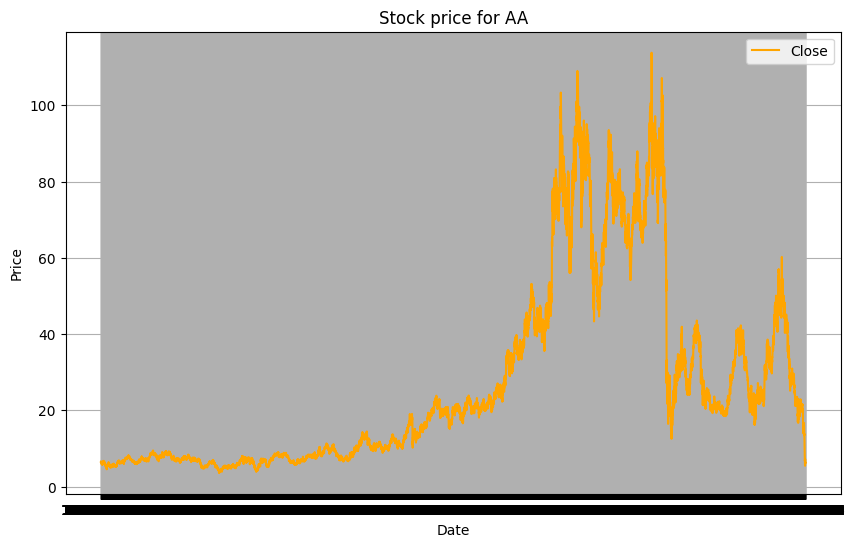

In [8]:
plot_stock_data(stock)

In [9]:
def moving_avg(stock,period):
    if stock.data is not None:
        df = pd.DataFrame(stock.data, columns=['Close'])
        df['SMA'] = df['Close'].rolling(window=period).mean()
        return df

In [10]:
moving_avg(stock,3)

,Close,SMA
0,6.532155,NaN
1,6.632280,NaN
2,6.632280,6.598905
3,6.624270,6.629610
4,6.408000,6.554850
...,...,...
14658,6.840000,7.066667
14659,6.550000,6.826667
14660,6.070000,6.486667
14661,6.160000,6.260000


In [11]:
moving_avg(stock,10)

,Close,SMA
0,6.532155,NaN
1,6.632280,NaN
2,6.632280,NaN
3,6.624270,NaN
4,6.408000,NaN
...,...,...
14658,6.840000,6.575
14659,6.550000,6.430
14660,6.070000,6.355
14661,6.160000,6.271


In [12]:
moving_avg(stock,20)

,Close,SMA
0,6.532155,NaN
1,6.632280,NaN
2,6.632280,NaN
3,6.624270,NaN
4,6.408000,NaN
...,...,...
14658,6.840000,8.8365
14659,6.550000,8.4705
14660,6.070000,8.0875
14661,6.160000,7.7485


In [13]:
max(stock.data['Close'].values)

np.float64(113.78205108642578)

In [14]:
def max_profit(stock,initial_cap,max_trade):
    j = initial_cap
    stock_held = 0
    trades_done = 0
    max_trade_allowed = max_trade // 2
    prices = pd.DataFrame(stock.data, columns=['Close']).values
    for i in range(1 ,len(prices)):
        #buy stock at a dip
        if prices[i] < prices[i-1] and trades_done < max_trade_allowed and capital >= prices[i]:
            stocks_to_buy = capital // prices[i]
            capital -= stocks_to_buy * prices[i]
            stock_held += stocks_to_buy
            trades_done += 1
        #sell stock at high
        elif prices[i] > prices[i-1] and stock_held > 0:
            capital += stock_held * prices[i]
            stock_held = 0
            trades_done +=1
        if trades_done >= max_trade:
            break
    if stock_held > 0:
        capital += stocks_held * prices[-1]

    return capital

            

In [15]:
def max_profit_naive(stock, capital=1000, max_trade=10):
    min_index = stock.data['Close'].idxmin()
    max_index = stock.data['Close'].idxmax()
    quantity = 0
    if max_index>min_index:
        buy_price = float(stock.data["Close"][min_index])
        quantity += capital//buy_price
        capital -= quantity*buy_price

        sell_price = float(stock.data["Close"][max_index])
        capital += quantity*sell_price
        quantity = 0
    return capital

In [16]:
initial_capital = 1000
trade_capital = max_profit_naive(stock,initial_capital)
print("Profit: {}, {}%".format(trade_capital, (trade_capital/initial_capital)*100))

Profit: 31065.35106778145, 3106.535106778145%


In [17]:
def max_corelation_tesla(directory,stock_symbol,tesla_sym="TSLA"):
    tesla = Stock(tesla_sym)
    tesla.load_data(directory)
    if tesla.data is None:
        print("Tesla data is not loaded")
    tesla.data['Date'] = pd.to_datetime(tesla.data['Date'])
    tesla.data = tesla.data.sort_values('Date')
    tesla_closing_price = tesla.data['Close']
    max_corelation = -1
    max_corelation_stock = None
    for symbol in stock_symbol:
        stock = Stock(symbol)
        try:
            stock.load_data(directory)
            stock.data['Date'] = pd.to_datetime(stock.data['Date'])
            stock.data = stock.data.sort_values('Date')
            merge_data = pd.merge(tesla.data[['Date','Close']],stock.data[['Date','Close']], on='Date',suffixes=('_tesla',f'_{symbol}'))
            correlation = merge_data['Close_tesla'].corr(merge_data[f'Close_{symbol}'])
            if correlation > max_corelation:
                max_corelation = correlation
                max_corelation_stock = symbol
        except FileNotFoundError as e:
            print(e)

    return max_corelation_stock,max_corelation

In [18]:
directory = "/home/ashli/ML/data/stocks/"
stock_symbol = ['AA','A','AAMC','AFT','AKTS','ALRN','AMEH','CORE','CRIS','TWIN','THBRU']

In [20]:
max_corr_stock,max_corr = max_corelation_tesla(directory,stock_symbol)

In [21]:
max_corr_stock

'THBRU'

In [22]:
max_corr

np.float64(0.8666932984039588)